<a href="https://colab.research.google.com/github/ngotancuong/datamining/blob/main/automl_tpot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Automated Machine Learning



In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import sys
os.chdir('/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/notebooks')
sys.path.append("/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/notebooks")
!pwd

/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/notebooks


# First Looks at the Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("../data/data_tpot.csv")
df.head()

,id,label,f1,f2,f3,c1
0,299340,1,2.114135,53.279725,0.715891,f
1,222579,1,2.750729,-68.723837,0.783546,m
2,152620,-1,-0.398702,37.517511,0.057790,m
3,201201,-1,6.107160,-178.689183,-0.825741,m
4,268691,1,6.485862,-157.894766,0.740175,m


Check for missing values or extreme values. It turns out the scales of the continuous features are quite different. It may be a good idea to normalize these depending on the model used.

In [ ]:
print(df.info(verbose=True))
df.iloc[1:].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      100000 non-null  int64  
 1   label   100000 non-null  int64  
 2   f1      100000 non-null  float64
 3   f2      100000 non-null  float64
 4   f3      100000 non-null  float64
 5   c1      100000 non-null  object 
dtypes: float64(3), int64(2), object(1)
memory usage: 4.6+ MB
None


,id,label,f1,f2,f3
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,199893.024440,-0.334293,0.996444,-50.013200,-0.000445
std,57668.536993,0.942474,3.464287,86.627756,0.578295
min,100000.000000,-1.000000,-4.999927,-199.999115,-0.999982
25%,150168.000000,-1.000000,-2.009128,-125.138030,-0.502098
50%,199789.000000,-1.000000,1.000554,-49.740820,0.000176
75%,249787.500000,1.000000,3.993037,24.898066,0.500042
max,299994.000000,1.000000,6.999791,99.999832,0.999995


Convert the -1 and +1 label values to be `False` and `True` respectively to make it easier to work with (this is a binary classifier problem).

In [ ]:
df.set_index(keys=['id'], inplace=True)
df.label = df.label.map(lambda x: True if x==1 else False)
df.head()

,label,f1,f2,f3,c1
id,,,,,
299340,True,2.114135,53.279725,0.715891,f
222579,True,2.750729,-68.723837,0.783546,m
152620,False,-0.398702,37.517511,0.057790,m
201201,False,6.107160,-178.689183,-0.825741,m
268691,True,6.485862,-157.894766,0.740175,m


Split the data into test, validation, and training sets before doing anything else to prevent data snooping and risk the ability to generalize well.

The validation compares different models without risk of overfitting since we have the test set to evaluate overall generalization performance once confident we've found a good model.

In [ ]:
rs = 123
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(
    df.loc[:, df.columns != 'label'], df.label, shuffle=True,
    stratify=df.label, random_state=rs, test_size=0.25)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_data, y_data, shuffle=True,
    stratify=y_data, random_state=rs, test_size=0.33)

# EDA

The data looks to be imbalanced with more False (-1) cases compared to True (+1).

In [ ]:
y_train.value_counts(normalize=True)

False    0.667124
True     0.332876
Name: label, dtype: float64

And there is and equal distribution of values accross the c1 categorical value of approximately 1/3 of observations falling into each one.

In [ ]:
X_train.c1.value_counts(normalize=True)

m    0.337393
n    0.334647
f    0.327960
Name: c1, dtype: float64

Visualize the data by plotting each pair of continuous variables (ignoring for them moment the categorical feature).

The classifications are color coded. Blue denotes False (-1) and yellow True (+1).

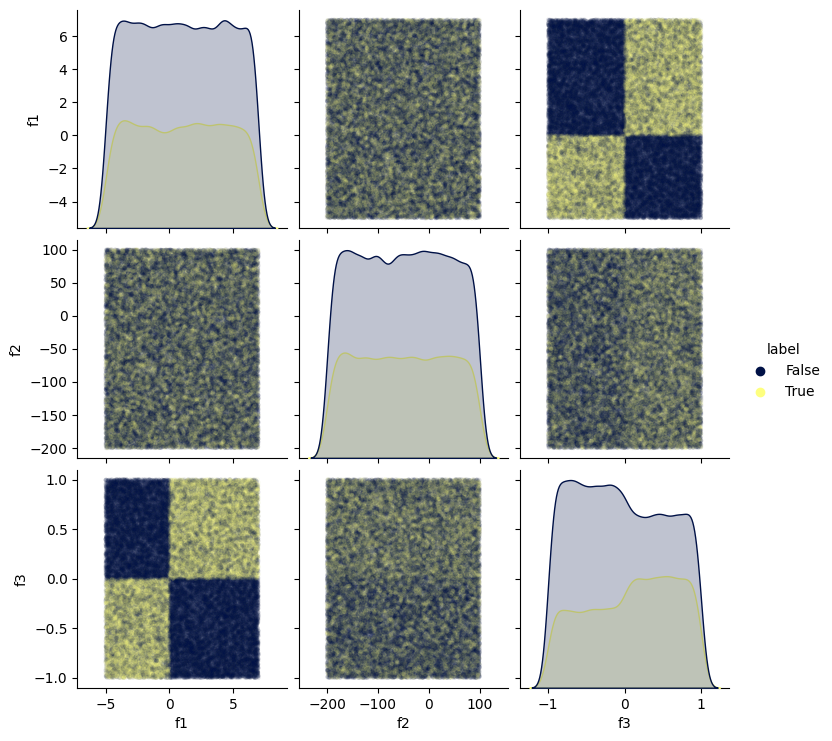

In [ ]:
import seaborn as sns

eda = X_train.copy()
eda['label'] = y_train

def plot_pairs(x, vars=['f1', 'f2', 'f3']):
    sns.pairplot(
        x, vars=vars, hue='label',
        plot_kws=dict(s=10, edgecolor='grey', linewidth=.1, alpha=.1),
        palette=sns.xkcd_palette(["navy blue", "faded yellow"]))

plot_pairs(eda);

Features f1 and f3 have the most seperation power. But blue and yellow do overlap.

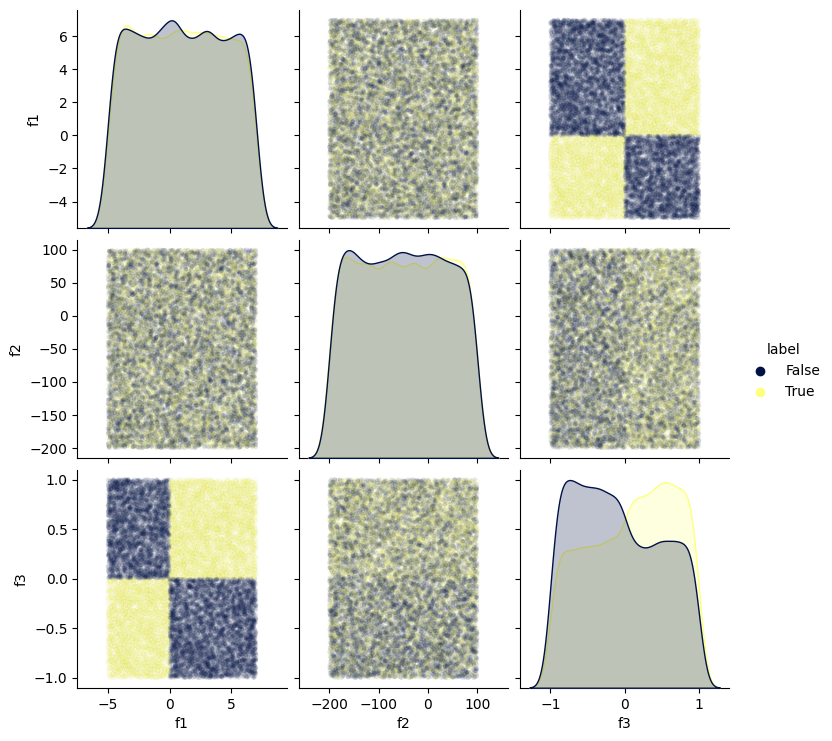

In [ ]:
plot_pairs(eda[eda.c1=='m']);

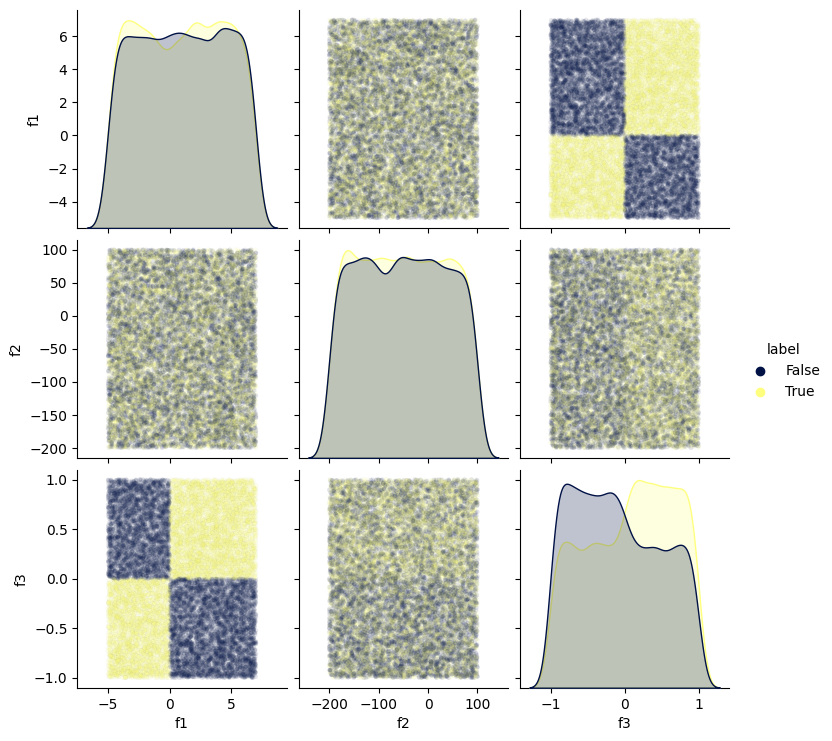

In [ ]:
plot_pairs(eda[eda.c1=='f']);

However, when `c1=='n'`, all observations appear to be False (-1).

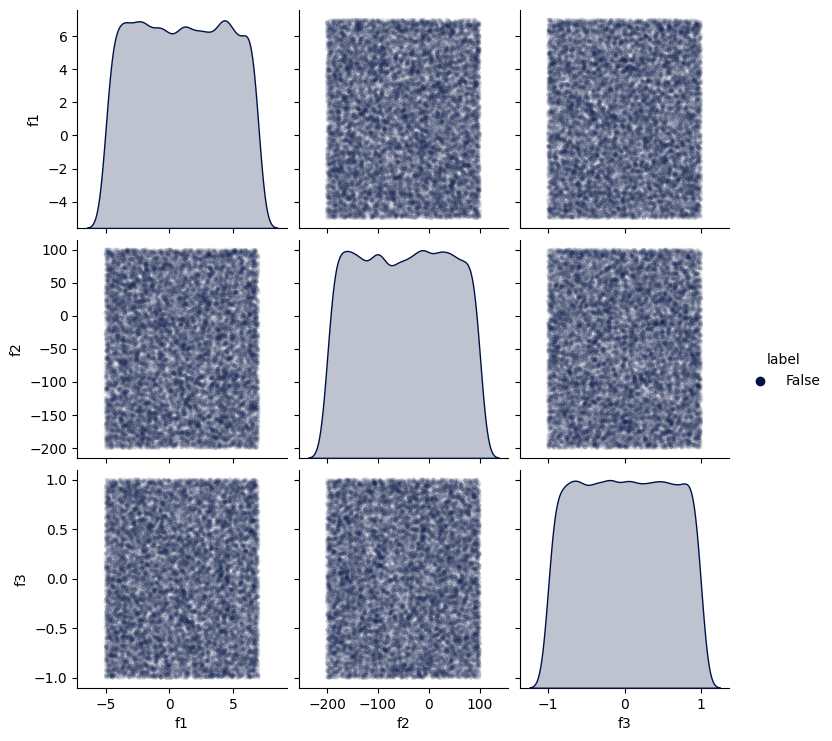

In [ ]:
plot_pairs(eda[eda.c1=='n']);

We need to transform the values `'m'`, `'f'`, and `'n'` to numbers (factors) to work with ML math.

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
c1_encoder = le.fit(X_train.c1)

X_train.c1 = c1_encoder.transform(X_train.c1)
X_valid.c1 = c1_encoder.transform(X_valid.c1)
X_test.c1 = c1_encoder.transform(X_test.c1)

In [ ]:
X_train.head()

,f1,f2,f3,c1
id,,,,
220466,3.719200,38.883307,0.155112,0
192570,-4.293955,41.388383,0.027261,1
267788,-3.049226,-190.471437,-0.608987,1
175577,3.145266,-152.071701,-0.545764,2
217426,-0.510158,21.682105,-0.471217,2


Below are some functions we'll use to evaluate the performance of the machine learning models we try. These will display a confusion matrix, the distribution of predicted probabilities, print out a classification report full of useful metrics to access the quality of the model's fit, and AUC curves.

In [ ]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import matplotlib.patheffects as path_effects
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn import svm, datasets
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cax = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=0)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_hist(ax, y, y_decision_score, decision_threshold, bins=20):
    # getting the score of the truly positive observations
    y_positive_decision_score = y_decision_score[y == True]
    # getting the score of the truly negative observations
    y_negative_decision_score = y_decision_score[y == False]

    #plot the two histograms, alpha (the transparency) is for the overlapping areas
    ax.hist(y_positive_decision_score, edgecolor='k', linewidth=1,
             bins=bins, alpha=0.4, label='True positives', color='b')
    ax.hist(y_negative_decision_score, edgecolor='k', linewidth=1,
             bins=bins, alpha=0.4, label='True negatives', color='r')

    ax.set_xlabel('Predicted Probability of +1 Class')
    ax.set_xticks([x/10 for x in range(11)])
    ax.set_xlim(0, 1)
    ymax = ax.get_ylim()[1]
    ax.set_ylim(0, ymax)

    ax.plot([decision_threshold]*2, [ymax, 0], color='k', linestyle='--', linewidth=2)
    ax.set_ylim(0, ymax)
    ax.set_title("Binary Classifer Performance")
    txt = text(decision_threshold-0.28, ax.get_ylim()[1]/2, 'Classify\n         -1 $\longleftarrow$')
    txt.set_path_effects([path_effects.withStroke(linewidth=5, foreground='w', alpha=0.8)])
    txt = text(decision_threshold, ax.get_ylim()[1]/2, '        Classify\n $\longrightarrow$ +1')
    txt.set_path_effects([path_effects.withStroke(linewidth=5, foreground='w', alpha=0.8)])

def plot_results(tpot, X, y):
    y_decision_score = tpot.predict_proba(X)[:,1]
    decision_threshold = 0.5
    y_decision = y_decision_score > decision_threshold
    cm = confusion_matrix(y.tolist(), y_decision)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=100)
    plot_confusion_matrix(cm, ['-1', '+1'], ax1)
    plot_hist(ax2, y, y_decision_score, decision_threshold, bins=11)
    ax2.legend()
    plt.show()

# Modeling

Let's run a popular, statistical learning algorithm: logistic regression.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=rs)
clf.fit(X_train, y_train)
cv = StratifiedKFold(n_splits=5, random_state=rs, shuffle=True)

Fold 1 results:


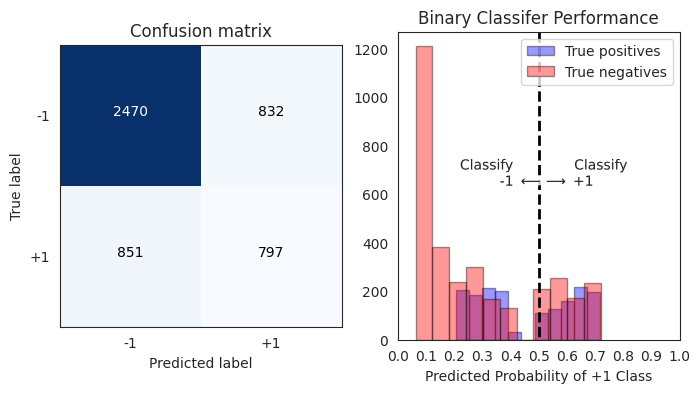

In [ ]:
for i, (_, indeces) in enumerate(cv.split(X_valid, y_valid)):
    print('Fold {0} results:'.format(i+1))
    cv_X = X_valid.iloc[indeces]
    cv_y = y_valid.iloc[indeces]
    sns.set_style("white")
    plot_results(clf, cv_X, cv_y)
    break

# Auto ML

In [ ]:
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=ef32d9d69df19793898461a85c48de660551bde4b1b9bc8ba93cd1ef922a04b3
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
from tpot import TPOTClassifier

config_dict = {
    'sklearn.linear_model.LogisticRegression': {
        'penalty': ["l1", "l2"],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'dual': [True, False]
    },
    'sklearn.preprocessing.MinMaxScaler': {},
    'sklearn.preprocessing.StandardScaler': {},
}

tpot = TPOTClassifier(generations=5, population_size=4,
                      scoring='neg_log_loss',
                      early_stop = 3, config_dict=config_dict,
                      periodic_checkpoint_folder='./checkpoint_tpot',
                      n_jobs=8, cv=5, verbosity=2, random_state=rs)
tpot.fit(X_train, y_train)
print(tpot.score(X_valid, y_valid))
tpot.export('tpot_pipeline.py')

Optimization Progress:   0%|          | 0/24 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.5271418945716588

Generation 2 - Current best internal CV score: -0.5271418945716588

Generation 3 - Current best internal CV score: -0.5271418945716588

Generation 4 - Current best internal CV score: -0.5271418945716588

The optimized pipeline was not improved after evaluating 3 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(input_matrix, C=5.0, dual=False, penalty=l2)
-0.5250927437843637


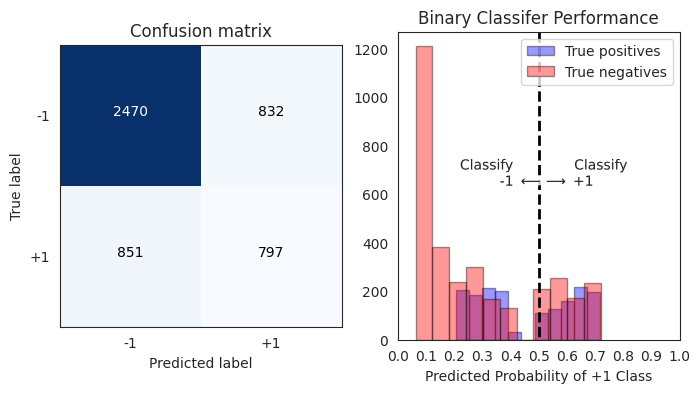

In [ ]:
for _, indeces in cv.split(X_valid, y_valid):
    cv_X = X_valid.iloc[indeces]
    cv_y = y_valid.iloc[indeces]
    sns.set_style("white")
    plot_results(tpot, cv_X, cv_y)
    break

The result are better, but this still isn't good. A logistic regression isn't a good model. Even when trying to scale the parameters to be comparable. We can run tpot wide open to explore more models.

In [ ]:
tpot = TPOTClassifier(generations=5, population_size=4,
                      scoring='neg_log_loss',
                      early_stop = 3,
                      periodic_checkpoint_folder='./checkpoint_tpot',
                      n_jobs=8, cv=5, verbosity=2, random_state=rs)
tpot.fit(X_train, y_train)
print(tpot.score(X_valid, y_valid))
tpot.export('tpot_pipeline.py')

Optimization Progress:   0%|          | 0/24 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -8.848885882234048e-05

Generation 2 - Current best internal CV score: -8.848885882234048e-05

Generation 3 - Current best internal CV score: -8.848885882234048e-05

Generation 4 - Current best internal CV score: -8.848885882234048e-05

The optimized pipeline was not improved after evaluating 3 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=7, min_samples_leaf=4, min_samples_split=5)
-0.0014563092278433393


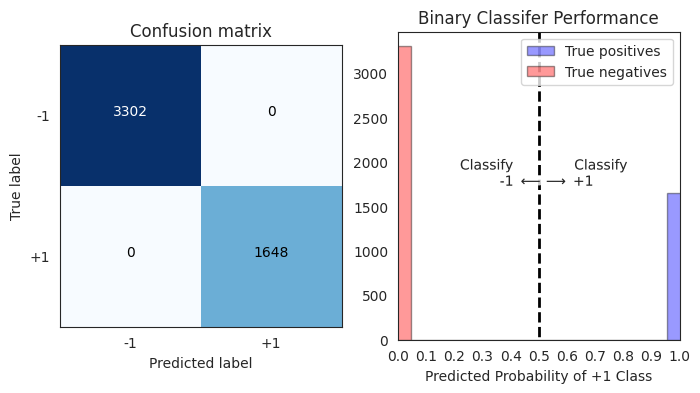

In [ ]:
for _, indeces in cv.split(X_valid, y_valid):
    cv_X = X_valid.iloc[indeces]
    cv_y = y_valid.iloc[indeces]
    sns.set_style("white")
    plot_results(tpot, cv_X, cv_y)
    break

The nice thing about a Decision Tree is we can verify the approach it's taking by looking at the tree itself. We'll do this with `graphviz`.

In [ ]:
from sklearn.tree import export_graphviz
clf = tpot.fitted_pipeline_.steps[0][1]
export_graphviz(clf, out_file='tree.dot')

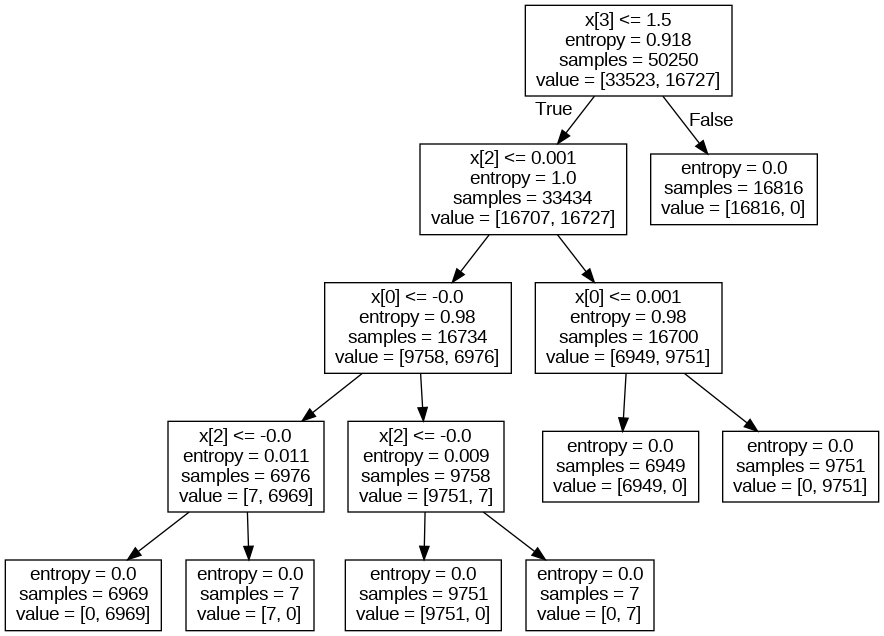

In [ ]:
!dot -Tpng tree.dot -o tree.png
from IPython.display import Image
Image('tree.png')

# Test for Generalization

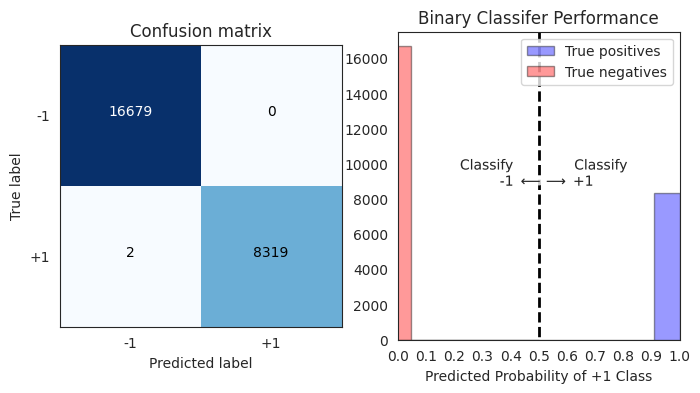

In [ ]:
plot_results(tpot, X_test, y_test)